# **Stage 1 # Job Description Parsing and evaluating 10 different approaches**

In [ ]:
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_trf
!pip install torch transformers sentencepiece
!pip install spacy-transformers
!pip install yake
!pip install rapidfuzz
!pip install skillNer
!pip install ojd_daps_skills

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Loading the Dataset

We loaded the job posting dataset and randomly sampled 250 job postings. 150 were manually annotated using Doccano to train a custom Named Entity Recognition (NER) model. The remaining 100 samples were used as an independent test set to evaluate our custom NER model and compare different skill extraction models.

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Loading the dataset
job_postings = pd.read_csv("job_postings_full.csv")

subset = job_postings.sample(n=250, random_state=42)
subset = subset.drop(columns=["skills_description", "pay_period", "final_yearly_salary"])

# Keeping 150 samples to annotate using Doccano and training a Custom NER
subset_ner  = subset.iloc[:150]
subset_ner.reset_index(drop=True, inplace=True)

# 100 samples for Testing
subset = subset.iloc[150:250]

subset.reset_index(drop=True, inplace=True)
subset.head()

,job_id,job_title,skills_list,skills_description,job_description,pay_period,final_yearly_salary
0,3904086353,Full Time - Financial Business Analyst with Re...,"business development,sales",Not Specified,Role: Financial Business Analyst with Regulato...,Not Specified,NaN
1,3902866582,Utilization Review Technician III,health care provider,Not Specified,Overview Prime Healthcare is an award - winnin...,Not Specified,NaN
2,3904372194,Store Manager,"sales,business development",Not Specified,"Our values start with our people, join a team ...",Not Specified,NaN
3,3903473867,"Physical Therapist - Home Health ($15,000 Sign...",health care provider,Not Specified,"Job Description $15, 000 Sign On Bonus Availab...",Not Specified,NaN
4,3902940999,Optometrist- Glaucoma Specialist,health care provider,Not Specified,Welcome! Were excited youre considering an opp...,Not Specified,NaN


In [ ]:
# Save to plain text (each job description on a new line) to annotate using Doccano
subset_ner['job_description'].to_csv("doccano_input.txt", index=False, header=False)


# Methodology and Experiments

## 1. Skill Extraction Approaches

To extract relevant skills from job descriptions and resumes, multiple approaches were tested to identify the most accurate, scalable, and context-aware method.

### 1.1 Custom SKILLS_DB Construction

A comprehensive skills database (`SKILLS_DB`) was compiled using:

*   ONET skill taxonomy
*   Domain-specific skills from the dataset
*   External curated lists (e.g., skillslabel.com)

This database served as the core for all matching-based approaches. The following code demonstrates how this database was constructed.

In [ ]:
# Load Skills from the skills labels.com
skill_list = pd.read_csv("Skills_data.csv")
skill_list = skill_list['Skills'].str.lower().tolist()

# Load ONET skill taxonomy and other lists
skills1 = pd.read_excel("Technology Skills.xlsx")
skills2 = pd.read_excel("Skills.xlsx")
skills3 = pd.read_excel("Work Styles.xlsx")
skills4 = pd.read_excel("Work Activities.xlsx")
skills5 = pd.read_csv("skills.csv")

skills1 = skills1['Example'].dropna().str.lower().unique().tolist()
skills2 = skills2['Element Name'].str.lower().unique().tolist()
skills3 = skills3['Element Name'].str.lower().unique().tolist()
skills4 = skills4['Element Name'].str.lower().unique().tolist()
skills5 = skills5[skills5['skill_name'] != 'other']['skill_name'].str.lower().unique().tolist()

# Combine all skill lists into a comprehensive database
SKILLS_DB = list(set(skills1 + skills2 + skills3 + skills4 + skills5 + skill_list))

print(f"Total number of unique skills collected for SKILLS_DB: {len(SKILLS_DB)}")

Total number of unique skills collected for SKILLS_DB: 9424


In [ ]:
# Convert the list to a pandas DataFrame before saving
SKILLS_DB_df = pd.DataFrame(SKILLS_DB, columns=["skills"])
SKILLS_DB_df.to_csv("SKILLS_DB.csv", index=False)

In [ ]:
SKILLS_DB = pd.read_csv("SKILLS_DB.csv")
SKILLS_DB = SKILLS_DB['skills'].dropna().tolist()
SKILLS_DB

['delta data systems agis',
 'thomson west cowles estate practice system',
 'teleconferencing software',
 'ascentis employee self-service',
 'financial accounting software',
 'thomson reuters westlawnext litigator',
 'eisi naviplan',
 'aerotriangulation adjustment software',
 'tecsys pointforce enterprise',
 'adrelevance',
 'minemax igantt',
 'product evaluation',
 'camstar systems camstar semiconductor suite',
 'soltrace',
 'treeview',
 'dataworks plus digital crimescene',
 'psychological evaluation',
 'adobe flex',
 'xyleme learning content management system lcms',
 'fault incident response',
 'bcs woodlands software the logger tracker',
 'accounting compliance software',
 'digital image collections',
 'netsuite netcrm',
 'novovision novopath',
 'web-est estimating software',
 'integra radionics neurosight arc',
 'jalada gmbh just translate',
 'google classroom',
 'techhackers iro @nalyst',
 'cedaron dexter evaluation & impairment rating',
 'leonardomd renaissance',
 'sage software s

### 1.2 Rule-Based and Embeddings Based Methods

This section details approaches that leverage rule-based pattern matching and traditional Natural Language Processing techniques, including embeddings for semantic understanding.

In [ ]:
import nltk
import pandas as pd

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(nltk.corpus.stopwords.words('english'))

def extract_skills_token_matching(input_text):
    if pd.isna(input_text):
        return set()

    word_tokens = nltk.tokenize.word_tokenize(input_text)

    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w.lower() not in stop_words]

    # remove the punctuation and non-alphabetic tokens
    filtered_tokens = [w for w in filtered_tokens if w.isalpha()]

    # generate unigrams, bigrams, and trigrams
    ngrams = list(map(' '.join, nltk.everygrams(filtered_tokens, 1, 3)))

    # we create a set to keep the results in.
    found_skills = set()

    # SKILLS_DB access the 'skills' column
    skills_db_lower = set([skill.lower() for skill in SKILLS_DB])

    # we search for each ngram in our skills database
    for ngram in ngrams:
        if ngram.lower() in skills_db_lower:
            found_skills.add(ngram)

    return list(found_skills)

# Example usage on a subsetdata
subset['tokenized_skills'] = subset['job_description'].apply(extract_skills_token_matching)
print("Token matching results on subset:")
display(subset[['job_description', 'tokenized_skills']].head())

#### 1.2.2 BERT Embeddings (Semantic Matching)

This method utilizes a pre-trained BERT-based Sentence Transformer model to understand the semantic meaning of words and phrases in the job descriptions. It generates vector representations (embeddings) for relevant phrases in the text and compares them to the embeddings of the skills in the `SKILLS_DB` using cosine similarity. This allows for the identification of skills that are semantically related to the text, even if the exact skill name is not present.

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
nltk.download('punkt')
nltk.download('stopwords')

# Initialize
stop_words = set(nltk.corpus.stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

# Skill list and embedding model
SKILLS_DB = [s.lower() for s in SKILLS_DB]
model = SentenceTransformer('all-MiniLM-L6-v2')
skill_embeddings = model.encode(SKILLS_DB, normalize_embeddings=True)

def extract_skills_semantic(text, top_n=10, threshold=0.85):
    if pd.isna(text) or not isinstance(text, str):
        return []

    # Tokenize and clean
    doc = nlp(text.lower())
    tokens = [token.text for token in doc if token.is_alpha and token.text not in stop_words]

    # Create phrases from tokens (you can tune this)
    phrases = list(set([' '.join(tokens[i:i+2]) for i in range(len(tokens)-1)] + tokens))

    # Embed the phrases
    phrase_embeddings = model.encode(phrases, normalize_embeddings=True)

    # Cosine similarity with known skill embeddings
    sim_matrix = cosine_similarity(phrase_embeddings, skill_embeddings)

    # For each phrase, find the most similar skill
    matched_skills = set()
    for i, similarities in enumerate(sim_matrix):
        best_score = np.max(similarities)
        if best_score >= threshold:
            matched_skill = SKILLS_DB[np.argmax(similarities)]
            matched_skills.add(matched_skill)

    return list(matched_skills)

# Example usage on a subsetdata
subset['BERT_Semantic_skills'] = subset["job_description"].apply(lambda x: extract_skills_semantic(x))
print("\nSemantic matching results on subset:")
display(subset[['job_description', 'BERT_Semantic_skills']].head())

#### 1.2.3 Combined Token + Embedding Matching

This approach combines the strengths of both exact token matching and semantic matching using BERT embeddings. It first identifies skills that are direct matches from the `SKILLS_DB` (using unigrams, bigrams, and trigrams). Then, it uses semantic similarity to find related skills based on phrase embeddings. The final output is a union of the skills found by both methods, aiming for a more comprehensive extraction.

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import numpy as np
import nltk
import pandas as pd
from tqdm.auto import tqdm

SKILLS_DB = [s.lower() for s in SKILLS_DB]

# Load models
model = SentenceTransformer('all-MiniLM-L6-v2')
skill_embeddings = model.encode(SKILLS_DB, normalize_embeddings=True)
nlp = spacy.load("en_core_web_sm")

# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))


def extract_combined_skills(text, threshold=0.85):
    # Lowercased text
    text = text.lower()

    # --- Exact Match: unigrams, bigrams, trigrams ---
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words]
    ngrams = list(map(' '.join, nltk.everygrams(tokens, 1, 3)))

    exact_matches = set()
    for token in ngrams:
        if token in SKILLS_DB:
            exact_matches.add(token)

    # --- Semantic Match: noun phrases vs SKILLS_DB ---
    doc = nlp(text)
    noun_phrases = [chunk.text.strip() for chunk in doc.noun_chunks]

    if noun_phrases:
        phrase_embeddings = model.encode(noun_phrases, normalize_embeddings=True)
        sim = cosine_similarity(phrase_embeddings, skill_embeddings)

        semantic_matches = set()
        for i, row in enumerate(sim):
            max_idx = np.argmax(row)
            if row[max_idx] >= threshold:
                semantic_matches.add(SKILLS_DB[max_idx])
    else:
        semantic_matches = set()

    # --- Final combined skills ---
    return list(exact_matches.union(semantic_matches))


# Example usage on a subset data
subset["Token_BERT_combined_skills"] = subset["job_description"].apply(lambda x: extract_combined_skills(x))
print("\nCombined matching results on subset:")
display(subset[['job_description', 'Token_BERT_combined_skills']].head())


#### 1.2.4 SpaCy PhraseMatcher

SpaCy's `PhraseMatcher` is a rule-based approach that efficiently finds occurrences of specific phrases (our skill list) within text. It's useful for identifying exact or near-exact matches of known skills.

In [ ]:
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
from tqdm.auto import tqdm


nlp = spacy.load("en_core_web_sm")
SKILLS_DB_lower = [skill.lower() for skill in SKILLS_DB]
patterns = [nlp.make_doc(skill) for skill in SKILLS_DB_lower]
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
matcher.add("SKILLS", patterns)

def extract_skills_spacy_matcher(text):
    doc = nlp(text.lower())  # Process individual text and lowercase
    matched_skills = set()
  # Use the PhraseMatcher to find matches
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        matched_skills.add(span.text)
    return list(matched_skills)


# Example usage on a subset data
tqdm.pandas()
subset['SpaCy PhraseMatcher'] = subset['job_description'].progress_apply(extract_skills_spacy_matcher)
print("\nSkills extracted using SpaCy PhraseMatcher:")
display(subset[['job_description', 'SpaCy PhraseMatcher']].head())

#### 1.2.5 YAKE (Yet Another Keyword Extractor)

YAKE is an unsupervised algorithm for keyword extraction. It identifies the most relevant keywords in a text based on statistical features of words and their context. While not exclusively a skill extractor, it can highlight important technical terms and phrases that often correspond to skills.

In [ ]:
# Step 1: Install YAKE
# !pip install yake

# Step 2: Imports
import yake
import pandas as pd
import re
from tqdm.auto import tqdm

def extract_keywords_yake(text, n_gram_range=(1, 3), top_n=30):

    clean_text = re.sub(r"(?<!\w)([A-Z][a-z]+)([A-Z][a-z]+)", r"\1 \2", text)  # fix missing spaces
    clean_text = re.sub(r"\n+", " ", clean_text)
    # Remove characters not typically part of skills
    clean_text = re.sub(r"[^a-zA-Z0-9\s.,+-/]", "", clean_text)

    kw_extractor = yake.KeywordExtractor(lan="en", n=n_gram_range[1], top=top_n, features=None)
    keywords_with_scores = kw_extractor.extract_keywords(clean_text)

    # Extract just the keyword strings
    keywords = [kw for kw, score in keywords_with_scores]

    # Filter out generic or undesirable keywords (customize list)
    generic_filter_words = ['job', 'description', 'company', 'team', 'experience', 'ability', 'year', 'week', 'hour', 'day', 'monday', 'friday']
    filtered_keywords = [kw for kw in keywords if not any(re.search(r'\b' + re.escape(w) + r'\b', kw.lower()) for w in generic_filter_words)]


    return list(filtered_keywords)

# Example usage on a subset data
tqdm.pandas()
subset['YAKE'] = subset['job_description'].progress_apply(extract_keywords_yake)
print("\nKeywords extracted using YAKE:")
display(subset[['job_description', 'YAKE']].head())

### 1.3 Transformer-Based NER Models

Transformer-based Named Entity Recognition (NER) models, often pre-trained on large text corpora and fine-tuned on specific datasets for skill extraction, can automatically identify and classify skills within text. Several models from the Hugging Face Transformers library were explored.

#### 1.3.1 `algiraldohe/lm-ner-linkedin-skills-recognition`

This model is fine-tuned to recognize various entity types in LinkedIn job postings, including different categories of skills such as `TECHNOLOGY`, `SOFT SKILL`, and `BUSINESS` (`BUS`), along with other entities like `location`, `experience`, and `education`.

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("algiraldohe/lm-ner-linkedin-skills-recognition")
model = AutoModelForTokenClassification.from_pretrained("algiraldohe/lm-ner-linkedin-skills-recognition")

pipe = pipeline("token-classification", model="algiraldohe/lm-ner-linkedin-skills-recognition", aggregation_strategy="first")

# Run pipeline
descriptions = subset["job_description"].tolist()  # Convert Series to list of strings
all_extracted_skills = []

for desc in descriptions:
    job_result = pipe(desc)
    skills = set(entity['word'].strip().lower() for entity in job_result)
    all_extracted_skills.append(list(skills))

# Add results to DataFrame
subset["algiraldohe_skills_lm_linkedin_ner"] = all_extracted_skills
# Display first 5 rows
display(subset[['job_description', 'algiraldohe_skills_lm_linkedin_ner']].head())

#### 1.3.2 `dslim/bert-base-NER`

This model is fine-tuned to recognize various entity types such as `Organizations (ORG)`, `Locations (LOC)`, `Persons`, and `MISC`.

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import torch

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

pipe = pipeline("token-classification", model="dslim/bert-base-NER", aggregation_strategy="first")

# Run pipeline
descriptions = subset["job_description"].tolist()  # Convert Series to list of strings
result = pipe(descriptions)

# Display results
results = pipe(descriptions[:5])  # Only the first 5 rows
for i, job_result in enumerate(results, start=1):
    print(f"\nJob Description {i}:")
    for entity in job_result:
        print(f"  Entity: {entity['word']}, Label: {entity['entity_group']}, Score: {entity['score']:.4f}")

#### 1.3.3 `juro95/xlm-roberta-finetuned-ner-5-with-skills`

This model is fine-tuned on a dataset to extract various entities, including skills, location, experience/seniority, occupation, and company name. While it extracts more than just skills, the skill entities can be isolated.

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForTokenClassification, pipeline
import pandas as pd
from tqdm.auto import tqdm

# Load model and tokenizer from TensorFlow weights
tokenizer = AutoTokenizer.from_pretrained("juro95/xlm-roberta-finetuned-ner-5-with-skills")
model = TFAutoModelForTokenClassification.from_pretrained("juro95/xlm-roberta-finetuned-ner-5-with-skills")

# Create pipeline
ner_pipeline = pipeline(
    "token-classification",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="first"
)

# Run only on first 5 descriptions
descriptions = subset["job_description"].tolist()
results = ner_pipeline(descriptions[:5])

# Display results
for i, job_result in enumerate(results, start=1):
    print(f"\nJob Description {i}:")
    for entity in job_result:
        print(f"  Entity: {entity['word']}, Label: {entity['entity_group']}, Score: {entity['score']:.4f}")


#### 1.3.4 `Pot-l/bert-ner-skills`

This BERT-based model is specifically fine-tuned for the task of skill extraction from text. It focuses on identifying and labeling entities that represent skills.

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import torch
from tqdm.auto import tqdm

tokenizer = AutoTokenizer.from_pretrained("Pot-l/bert-ner-skills")
model = AutoModelForTokenClassification.from_pretrained("Pot-l/bert-ner-skills")

pipe = pipeline("token-classification", model="Pot-l/bert-ner-skills", aggregation_strategy="first")

# Run pipeline
descriptions = subset["job_description"].tolist()  # Convert Series to list of strings
result = pipe(descriptions)

# Display results
results = pipe(descriptions[:5])
for i, job_result in enumerate(results, start=1):
    print(f"\nJob Description {i}:")
    for entity in job_result:
        print(f"  Entity: {entity['word']}, Label: {entity['entity_group']}, Score: {entity['score']:.4f}")

#### 1.3.5 `jjzha/jobbert_skill_extraction `

This model targets soft skills, responsibilities, and descriptive qualities with high token-level granularity.

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import torch

tokenizer = AutoTokenizer.from_pretrained("jjzha/jobbert_skill_extraction")
model = AutoModelForTokenClassification.from_pretrained("jjzha/jobbert_skill_extraction")

pipe = pipeline("token-classification", model="jjzha/jobbert_skill_extraction", aggregation_strategy="first")

# Run pipeline
descriptions = subset["job_description"].tolist()

results = []

for desc in descriptions:
    # Tokenize and truncate to 512 tokens
    tokens = tokenizer(desc, max_length=512, truncation=True, return_tensors="pt")
    decoded_text = tokenizer.decode(tokens["input_ids"][0], skip_special_tokens=True)

    # Pass truncated decoded text to pipeline
    res = pipe(decoded_text)
    results.append(res)

In [ ]:
def merge_bi_entities(entities):
    merged = []
    current = ""
    for entity in entities:
        word = entity['word']
        label = entity['entity_group']
        score = entity['score']

        if label == "B":
            if current:
                merged.append(current.strip())
            current = word
        elif label == "I":
            current += " " + word
        else:
            if current:
                merged.append(current.strip())
            current = word  # fallback for unknown tags

    if current:
        merged.append(current.strip())

    return merged

for i, job_result in enumerate(results, start=1):
    merged_entities = merge_bi_entities(job_result)
    print(f"\nJob Description {i}:")
    for skill in merged_entities:
        print(f"  Skill: {skill}")

In [ ]:
# Save predictions
jobbert_skill_extraction = []
for job_result in results:
    merged_entities = merge_bi_entities(job_result)
    cleaned_skills = [s.lower().strip() for s in merged_entities]
    jobbert_skill_extraction.append(list(set(cleaned_skills)))

# Add to DataFrame
subset["jobbert_skill_extraction"] = jobbert_skill_extraction

# Display first 5 rows
display(subset[['job_description', 'jobbert_skill_extraction']].head())

### 1.4 SkillNER

SkillNER is a Python library designed specifically for extracting skills from job postings. It leverages spaCy and a built-in skill database (based on ESCO) to identify and categorize skills, providing both direct matches and n-gram based suggestions.

In [ ]:
# Step 1: Install and Load SkillNER
#!pip install skillNer
#!python -m spacy download en_core_web_lg

# Step 2: Imports
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
from skillNer.general_params import SKILL_DB as SKILL_DB_SKILLNER
from skillNer.skill_extractor_class import SkillExtractor
from tqdm.auto import tqdm

# Step 3: Load language model and SkillExtractor
nlp_lg = spacy.load("en_core_web_lg")
skill_extractor_skillner = SkillExtractor(nlp_lg, SKILL_DB_SKILLNER, PhraseMatcher)

# Step 4: Define a skill extraction function for SkillNER
def extract_skills_skillner(text):
        try:
            annotations = skill_extractor_skillner.annotate(text)

            # Extract skills from both full_matches and ngram_scored
            full_match_skills = [match['doc_node_value'] for match in annotations.get('results', {}).get('full_matches', [])]
            ngram_scored_skills = [match['doc_node_value'] for match in annotations.get('results', {}).get('ngram_scored', [])]

            # Combine, clean, and deduplicate
            all_skills = full_match_skills + ngram_scored_skills
            cleaned_skills = list(set([s.lower().strip() for s in all_skills]))

            return cleaned_skills

        except Exception as e:
            print(f"Error processing text: {e}")
            return []

# Example usage on a subset data
tqdm.pandas()
subset['SkillNER'] = subset['job_description'].progress_apply(extract_skills_skillner)
print("\nSkills extracted using SkillNER:")
display(subset[['job_description', 'SkillNER']].head())

### 1.5 ojd_daps_skills (Nesta Skill Extraction)

The `ojd_daps_skills` library, developed by Nesta, provides a pre-trained model for extracting skills from job advertisements based on recognized taxonomies like Lightcast and ESCO. It identifies skill mentions and maps them to a standardized list.

In [ ]:
# Step 1: Import and initialize
# !pip install ojd_daps_skills

from ojd_daps_skills.extract_skills.extract_skills import SkillsExtractor
import pandas as pd
from tqdm.auto import tqdm

# Step 2: Initialize the skill extractor with a taxonomy
# Choose either "lightcast" or "esco"
skill_extractor_nesta = SkillsExtractor(taxonomy_name="lightcast")

# Step 3: Define a function to extract mapped skills
def extract_nesta_mapped_skills(text):
    results = skill_extractor_nesta([text])
    if results:
        mapped_skills = results[0]._.mapped_skills
        if mapped_skills:
            return list(
                set(
                    skill_dict['ojo_skill']
                    for skill_dict in mapped_skills
                    if skill_dict is not None and 'ojo_skill' in skill_dict
                )
            )
    return []  # If results or mapped_skills is None or empty

# Example usage on a subset data
tqdm.pandas()
subset['Lightcast (Nesta)'] = subset['job_description'].progress_apply(extract_nesta_mapped_skills)
print("\nSkills extracted using ojd_daps_skills (Lightcast taxonomy):")
display(subset[['job_description', 'Lightcast (Nesta)']].head())

### 1.6 LLM-Based Extraction

Leveraging large language models (LLMs) like those available through OpenRouter API allows for a more nuanced and context-aware approach to skill extraction. By providing a structured prompt, the LLM can identify and categorize skills, education, and experience from free-form job description text.

In [ ]:
import json
import base64
import os
import pandas as pd
from google import genai
from google.genai import types
import time

GEMINI_API_KEY = "Your Gemini Api Key"

# Initialize Gemini Client
client = genai.Client(api_key=GEMINI_API_KEY)
model = "gemini-2.5-flash-lite-preview-06-17"
generate_content_config = types.GenerateContentConfig(
    temperature=0.8,
    thinking_config=types.ThinkingConfig(thinking_budget=0),
    response_mime_type="text/plain",
)

def build_prompt(job_text):
    return f"""
You are an expert AI trained to extract structured information from job descriptions.

Please analyze the following job description and extract all unique key terms or phrases into four categories:

- **hard_skills**: Concrete, technical, or domain-specific skills or tools (e.g., Python, AutoCAD, SQL, financial modeling) **that are explicitly stated**.
- **soft_skills**: Clearly mentioned interpersonal or behavioral traits (e.g., teamwork, time management, leadership).
- **education**: Exact degrees, certifications, or academic requirements mentioned in the job description (e.g., "Bachelor’s in Engineering", "MBA", "Certified Public Accountant").
- **experience**: Specific requirements around years of experience, industry experience, or role-based experience mentioned in the job text (e.g., "5+ years in project management", "experience in healthcare").

Only return values that are **verbatim or clearly paraphrased from the text**. Do not include generic skills, vague summaries, or industry norms unless they are stated directly in the job description.
Do not invent, hallucinate, or return generalized content.

Respond ONLY in this JSON format (no explanations or extra text):

{{
  "hard_skills": [...],
  "soft_skills": [...],
  "education": [...],
  "experience": [...]
}}

Job Description:
\"\"\"{job_text}\"\"\"
""".strip()

def clean_json_fences(s: str) -> str:
    """Strip markdown fences and leading 'json' token."""
    if not isinstance(s, str):
        return s
    s = s.strip()
    # Remove ```json or ``` at the start
    for prefix in ("```json", "```"):
        if s.startswith(prefix):
            s = s[len(prefix):].strip()
    # Remove trailing ```
    if s.endswith("```"):
        s = s[:-3].strip()
    # Remove leading 'json' token if present
    if s.lower().startswith("json"):
        s = s[4:].strip()
    return s

def query_gemini(job_text):
    contents = [
        types.Content(
            role="user",
            parts=[{"text": build_prompt(job_text)}]
        )
    ]
    try:
        raw = ""
        for chunk in client.models.generate_content_stream(
            model=model,
            contents=contents,
            config=generate_content_config,
        ):
            if chunk.text:  # Only append if not None or empty
                raw += chunk.text
        return clean_json_fences(raw)
    except Exception as e:
        print(f"Error: {e}")
        return None

# Create a list to store responses
llm_responses = []

for idx, row in subset.iterrows():
    print(f"Processing index {idx}...")
    job_text = row["job_description"]
    result = query_gemini(job_text)
    llm_responses.append(result)
    time.sleep(4.1)  # Gemini's 15 RPM limit (4.1 sec delay)

# Add the responses to your DataFrame
subset['LLM_response'] = llm_responses

In [ ]:
import json

def extract_llm_components(response_text):
    try:
        cleaned = clean_json_fences(response_text)
        data = json.loads(cleaned)

        llm_skills = data.get("hard_skills", []) + data.get("soft_skills", [])
        llm_education = data.get("education", [])
        llm_experience = data.get("experience", [])

        return {
            "LLM_skills": llm_skills,
            "LLM_education": llm_education,
            "LLM_experience": llm_experience
        }
    except Exception as e:
        print(f"Failed to parse LLM response: {e}")
        return {
            "LLM_skills": [],
            "LLM_education": [],
            "LLM_experience": []
        }


In [ ]:
# Example usage on a subset data
llm_results_df = subset["LLM_response"].apply(extract_llm_components).apply(pd.Series)
subset = pd.concat([subset, llm_results_df], axis=1)
print("\nSkills extracted using LLM (gemini-2.5-flash-lite-preview-06-17)")
display(subset[['job_description', 'LLM_skills', 'LLM_education', 'LLM_experience']].head())

,job_description,LLM_skills,LLM_education,LLM_experience
0,Role: Financial Business Analyst with Regulato...,"[financial principles, regulatory requirements...","[Masters degree in Finance, accounting, or Bus...","[8+ years of exp., Experience preparing and de..."
1,Overview Prime Healthcare is an award - winnin...,"[Microsoft office proficiency, faxing, mailing...",[Bachelors degree],[four years of relevant experience]
2,"Our values start with our people, join a team ...","[PDTs, registers, PC, basic mathematical calcu...",[],[Five or more years of Store management experi...
3,"Job Description $15, 000 Sign On Bonus Availab...","[physical therapy services, customer relations...",[],[seven successful years]
4,Welcome! Were excited youre considering an opp...,"[Optometry, Glaucoma, Ophthalmology, team - ba...","[Doctor of Optometry, fellowship in Glaucoma]","[Assistant Professor, Associate Professor, Pro..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


### 1.7 Custom Named Entity Recognition (NER) Model Development

In [ ]:
# 1. INSTALL & SETUP ENVIRONMENT
# ------------------------------

# !pip install -U spacy[transformers] torch transformers sentencepiece
import os
import json, random
import spacy
from spacy.training import offsets_to_biluo_tags
from spacy.tokens import DocBin
import spacy_transformers
from spacy.cli.init_config import init_config

# Download spaCy’s transformer model
# !python -m spacy download en_core_web_trf


# 2. DATA LOADING, VALIDATION & CLEANING             │
# --------------------------------------

# Load transformer pipeline for validation
nlp = spacy.load("en_core_web_trf")

# Load annotated data
jsonl_path = "annotated_samples.jsonl"
with open(jsonl_path, 'r', encoding='utf-8') as f:
    annotated_data = [json.loads(line) for line in f]

# Validate and clean annotations
clean_data = []
invalid_count = 0

for entry in annotated_data:
    text = entry["text"]
    spans = entry.get("label", [])
    entities = [(start, end, label) for start, end, label in spans]

    try:
        doc = nlp.make_doc(text)
        # Validate using BILUO tag scheme
        offsets_to_biluo_tags(doc, entities)
        clean_data.append((text, {"entities": entities}))
    except Exception as e:
        print(f"\n Misaligned entity detected:\nText: {text}\nEntities: {entities}\nError: {e}")
        invalid_count += 1

print(f" Clean examples retained: {len(clean_data)}")
print(f" Misaligned examples removed: {invalid_count}")

# Convert to spaCy Training Format
doc_bin = DocBin()
for text, ann in clean_data:
    doc = nlp.make_doc(text)
    ents = [doc.char_span(start, end, label=label) for start, end, label in ann["entities"]]
    doc.ents = [span for span in ents if span is not None]
    doc_bin.add(doc)

doc_bin.to_disk("clean_train.spacy")

# 3. SPLIT TRAIN/DEV SET
# ----------------------

db = DocBin().from_disk("clean_train.spacy")
docs = list(db.get_docs(nlp.vocab))
random.shuffle(docs)
split = int(len(docs) * 0.85)
train_docs = docs[:split]
dev_docs = docs[split:]
DocBin(docs=train_docs).to_disk("train.spacy")
DocBin(docs=dev_docs).to_disk("dev.spacy")

print(f" Split complete. Train: {len(train_docs)} | Dev: {len(dev_docs)}")


 Split complete. Train: 127 | Dev: 23


In [ ]:
# CONFIG GENERATION (Transformer + NER)
# -------------------------------------
from pathlib import Path

# Create spaCy config file
cfg = init_config(
    lang="en",
    pipeline=["transformer","ner"],
    optimize="accuracy",
    gpu=True,
    silent=False,
)
cfg.to_disk("config.cfg")
print("\n".join(open("config.cfg").read().splitlines()[:8]))


init_config signature: (*, lang: str = 'en', pipeline: List[str] = ['tagger', 'parser', 'ner'], optimize: str = <Optimizations.efficiency: 'efficiency'>, gpu: bool = False, pretraining: bool = False, silent: bool = True) -> confection.Config
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: accuracy
- Hardware: GPU
- Transformer: roberta-base
✔ Auto-filled config with all values
[paths]
train = null
dev = null
vectors = null
init_tok2vec = null

[system]
gpu_allocator = "pytorch"


In [ ]:
# TRAINING THE PIPELINE
# ---------------------

!python -m spacy train config.cfg \
    --output ./output \
    --paths.train train.spacy \
    --paths.dev dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
tokenizer_config.json: 100% 25.0/25.0 [00:00<00:00, 154kB/s]
config.json: 100% 481/481 [00:00<00:00, 2.73MB/s]
vocab.json: 100% 899k/899k [00:00<00:00, 2.00MB/s]
merges.txt: 100% 456k/456k [00:00<00:00, 2.13MB/s]
tokenizer.json: 100% 1.36M/1.36M [00:00<00:00, 5.85MB/s]
2025-07-27 06:20:38.653686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753597238.903999   11705 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753597238.969756   11705 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-27 06:20:39.481584: I tensor

In [ ]:
import spacy
import pandas as pd

# Load the custom-trained NER model
nlp = spacy.load("/content/output/model-best")

# Define a function to extract and group entities
def extract_custom_ner(text):
    doc = nlp(text)
    hard_skills = set()
    soft_skills = set()
    education = set()
    experience = set()

    for ent in doc.ents:
        label = ent.label_.lower()
        if label == "hard_skill":
            hard_skills.add(ent.text.strip())
        elif label == "soft_skill":
            soft_skills.add(ent.text.strip())
        elif label == "education":
            education.add(ent.text.strip())
        elif label == "experience":
            experience.add(ent.text.strip())

    return {
        'custom_ner_skills': list(hard_skills.union(soft_skills)),
        'custom_ner_education': list(education),
        'custom_ner_experience': list(experience)
    }

# Apply to each job description
extracted = subset['job_description'].apply(extract_custom_ner)

# Convert extracted dicts to separate columns
subset = pd.concat([subset, extracted.apply(pd.Series)], axis=1)

# View results
subset[['job_description', 'custom_ner_skills', 'custom_ner_education', 'custom_ner_experience']].head()


,job_description,custom_ner_skills,custom_ner_education,custom_ner_experience
0,Role: Financial Business Analyst with Regulato...,"[Financial Business Analyst, strong understand...","[Masters degree in Finance, accounting, or Bus...","[Experience in the use of, Experience preparin..."
1,Overview Prime Healthcare is an award - winnin...,"[coordinating phone calls, scan all related co...","[Completion of a medical terminology course, B...",[four years of relevant experience required]
2,"Our values start with our people, join a team ...",[Ensures compliance with Ross personnel polici...,[],[Five or more years of Store management experi...
3,"Job Description $15, 000 Sign On Bonus Availab...","[empathy, Must be able to handle potential pro...",[],[]
4,Welcome! Were excited youre considering an opp...,"[providing management services, clinical resea...","[Doctor of Optometry or foreign equivalent, fe...",[]


In [ ]:
# Saving the trained Custom NER model
# -----------------------------------

import os
import shutil
from google.colab import files

# Zip the model-best directory
shutil.make_archive('/content/output/model-best', 'zip', '/content/output/model-best')

'/content/output/model-best1.zip'

In [ ]:
nlp = spacy.load("/content/output/model-best")
test_text = """ Job Description Kenvue is currently recruiting for -  Sr Manager  -  Project Management  -  Neutrogena This position reports to Neutrogena Operations Leader and is based at Skillman, N J ( Kenvues corporate headquarters is currently located in Skillman NJ, but is scheduled to move to Summit, NJ in or around early 2025 . ) Who We Are At Kenvue , we realize the extraordinary power of everyday care. Built on over a century of heritage and rooted in science, were the house of iconic brands  -  including Neutrogena, Aveeno, Tylenol, Listerine, Johnsons and BAND - AID Brand Adhesive Bandages that you already know and love. Science is our passion; care is our talent. Our global team is made up of ~ 22, 000 diverse and brilliant people, passionate about insights, innovation and committed to delivering the best products to our customers. With expertise and empathy, being a Kenvuer means having the power to impact the life of millions of people every day. We put people first, care fiercely, earn trust with science and solve with courage and have brilliant opportunities waiting for you! Join us in shaping our futureand yours. For more information, click here . Role reports to -  Neutrogena Operations Leader Location -  Skillman, NJ ( Kenvues corporate headquarters is currently located in Skillman NJ, but is scheduled to move to Summit, NJ in or around early 2025 . ) Travel % -  10 % Pay -  $113, 000 to $195, 500 What You Will Do The Sr Manager  -  Project Management  -  Neutrogena is responsible for Directly lead, coach and develop a team of project managers who support regional Innovation and Life Cycle Management programs/projects. Possess strong communication and acumen skills to lead the appropriate project portfolio/program discussions with Stakeholders, Sr. Leaders and Governance/Decision Making forums. Ability to produce and present clear status reports in a tactful and candid manner. Work closely with the Commercial, R&D, and Supply Chain leaders to ensure a robust portfolio pipeline of projects in the Innovation/Life Cycle Management space. Have strong Portfolio and analytics capability to drive the portfolio of projects, priorities to be in line with the Business priorities in a compliant and optimal manner. Lead appropriate Governance forums as required in the Innovation/Life Cycle Management space. Be the PMO subject matter expert and liaison for PMO and business partners, keeping the organization appropriately informed of Program and/or New Product risks/mitigations and developments. Lead a portfolio of major or complex programs/projects to support of the NA Innovation and Life Cycle Management portfolio strategy. Emphasis will be on delivering projects on - time, within budget in a compliant and reliable manner. May be required to lead global initiatives. Identifies, Leads and Deploys improvements in the current project/program management practices for the Innovation or Life Cycle Management portfolio. Act as an PMO knowledge expert for the region during interactions with Global business partners and External business partners, as required for their appropriate programs Key Responsibilities Ability to lead, train and mentor project managers in appropriate project and portfolio management capabilities Ability to understand and articulate how financial decisions for programs/projects affect the bottom line; knowledge about how financial principles and practices impact the business Ability to motivate department and project team members, to set achievable objectives, to maintain a positive outlook, to take responsibility, to make decisions, to hold self and team members accountable and to provide constructive feedback Ability to analyze their respective portfolio utilizing available tools & techniques to derive business conclusions and enable effective portfolio decision making Ability to undertake continual adjustments with stakeholders in a persuasive manner, to keep projects on course by use of positive win/win attitude Ability to analyze the future impact of decisions by taking a big - picture approach, to strategically position projects with - in the business to relate to short and long - term objectives Define business case, develop and implement project charters and metrics; obtain stakeholder alignment; identify/manage project risks and develop risk mitigation plans; be a source of conflict resolution; manage project budgets Ability to establish clear project scope (In & Out), define the extent of the project; define project deliverables; establish milestones and a detailed time line; define/align to resource requirements and establish a total project budget Understand and know how to use project & portfolio management tools and techniques to be compliant with the use of agreed Regional PMO practices, use of Portfolio systems (Planisware), use of appropriate Regional Governance forums Understand and know how to perform cost/benefit analysis; identify budgetary needs and maintain focus on budget. Be aware of the approach to utilizing existing functional procedures that impact the project/ program Responsible for measuring and reporting on the Innovation and Life Cycle Management Dashboard/Scorecard metrics. Ability to identify and make optimal use of resources Required Qualifications Bachelors degree is required. Minimum of 10 years combined business experience in two or more functional areas Project Management, Supply Chain, Operations, Procurement, Engineering, R&D, Sales, Marketing or Finance is required. Minimum of 5 years demonstrated experience managing projects in a formal Project Management role. A demonstrated history of managing complexity is required. Experience launching new products in a GMP and regulated environment (Pharmaceutical, Medical Device and Diagnostics, or Consumer Products) is required. Strong understanding of the commercial landscape and consumer industry experience in a fast - paced environment is required. Ability to shape and meet the project objectives by successfully managing, tracking and implementing successful strategies in regard to scope, quality, time and cost is required. Solid business knowledge, sound judgment, can communicate with technical partners, can influence stakeholders and change management skills is required. Experience with financial statements and methodologies (P&Ls, Balance Sheets, COGs, GPs, ROAs, NPVs, IRRs) is required. Experience with Microsoft Project & Excel is required. This position may require up to 10% travel domestically and internationally Desired Qualifications MBA or an advanced degree. Experience managing people is highly preferred. Experience managing a portfolio of projects highly preferred. Experience with Six Sigma/Process Excellence Tools, Training and/or Certification is preferred. Project Management Training and/or Project Management Professional (PMP) Certified experience is preferred. Whats In It For You Annual base salary for new hires in this position ranges from $113, 000 to $195, 500. This takes into account a number of factors including work location, the candidates skills, experience, education level & other job - related factors. Competitive Total Rewards Package -  Paid Company Holidays, Paid Vacation, Volunteer Time & More! Learning & Development Opportunities Employee Resource Groups This list could vary based on location/region Note -  Total Rewards at Kenvue include salary, bonus (if applicable) and benefits. Your Talent Access Partner will be able to share more about our total rewards offerings and the specific salary range for the relevant location(s) during the recruitment & hiring process.
Kenvue is proud to be an Equal Opportunity Employer. All qualified applicants will receive consideration for employment based on business needs, job requirements, and individual qualifications, without regard to race, color, religion, sex, sexual orientation, gender identity, age, national origin, protected veteran status, or any other legally protected characteristic, and will not be discriminated against on the basis of disability. Primary Location NA - US - New Jersey - Skillman Job Function New Product Intro - Life Cycle Mgmt Organization Johnson & Johnson Consumer Inc. Job Qualifications What we are looking for
"""
doc = nlp(test_text)

# Extract unique (text, label) pairs
unique_entities = set((ent.text.strip(), ent.label_) for ent in doc.ents)

# Print sorted output
for text, label in unique_entities:
    print(f"{text} ====> {label}")

define project deliverables ====> hard_skill
Work closely with the Commercial, R&D, and Supply Chain ====> soft_skill
Finance ====> hard_skill
managing ====> hard_skill
subject matter expert ====> hard_skill
Ability to analyze the future impact of decisions by taking a big - picture approach ====> hard_skill
Project Management Training and/or Project Management Professional (PMP) Certified ====> hard_skill
hold self and team members ====> soft_skill
Experience managing a portfolio of projects ====> experience
maintain a positive outlook ====> soft_skill
provide constructive feedback ====> soft_skill
Ability to understand and articulate how financial decisions for programs/projects ====> hard_skill
set achievable objectives ====> soft_skill
tracking ====> hard_skill
make decisions ====> soft_skill
Ability to motivate department and project team members ====> soft_skill
take responsibility ====> soft_skill
Volunteer Time ====> soft_skill
Solid business knowledge ====> hard_skill
ensure a

In [ ]:
# Save all skills, education and experience extracted using different models
subset.to_csv("subset_with_all_response.csv", index=False)

In [ ]:
# Loading NER model
# ! pip install spacy_transformers
# ! python -m spacy download en_core_web_trf
import zipfile
import os

zip_file_path = '/content/model-best.zip' # Replace with the path to the zip file
extract_dir = '/content/model-best/' # Directory to extract the model

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted model to: {extract_dir}")

Extracted model to: /content/model-best/


In [ ]:
import spacy
from spacy import displacy

# Load your trained model
nlp = spacy.load("/content/model-best")

# Your job description text
test_text = """ Investment bank is looking to hire a senior software engineer. The ideal candidate is a self - motivated, multi - tasker, and demonstrated team - player.
You will be a lead developer responsible for the development of new software products and enhancements to existing products. You should excel in working with large - scale applications and frameworks
and have outstanding communication and leadership skills. Responsibilities Writing clean, high - quality, high - performance, maintainable code Develop and support software including applications,
database integration, interfaces, and new functionality enhancements Coordinate cross - functionally to insure project meets business objectives and compliance standards Support test and deployment of
new products and features Participate in code reviews. Qualifications Bachelor's degree in Computer Science (or related field)3+ years of relevant work experience Expertise in Object Oriented Design,
Database Design, and XML Schema Experience with Agile or Scrum software development methodologies Ability to multi - task, organize, and prioritize work
"""

# Process with NER
doc = nlp(test_text)

# Define custom colors for each entity
colors = {
    "HARD_SKILL": "#E1F8DC",
    "SOFT_SKILL": "#FFE7C7",
    "EDUCATION": "#FFB6C1",
    "EXPERIENCE": "#B3E5FF",
}

# Set displacy options
options = {
    "ents": list(colors.keys()),  # Entities to display
    "colors": colors              # Color mapping
}

# Render the doc
displacy.render(doc, style="ent", options=options, jupyter=True)


# **Model performance evaluation**

A hold-out set of 100 job descriptions was annotated with ground truth labels for True skills, True education, and True experience. These annotations served as the benchmark for evaluating the performance of each model. While all models were primarily evaluated on True skills, a more granular comparison of True education and True experience was conducted for the top-performing models in a subsequent analysis

In [ ]:
true_annotations = pd.read_csv('true_annotations.csv')
true_annotations.head()

,job_id,job_title,skills_list,job_description,information_extracted,True_skills,True_education,True_experience
0,3904086353,Full Time - Financial Business Analyst with Re...,"business development,sales",Role: Financial Business Analyst with Regulato...,"[""regulatory reporting"", ""analyzing financial ...","['regulatory reporting', 'analyzing financial ...","['Masters degree in Finance, accounting', 'Mas...",['8+ years of experience']
1,3902866582,Utilization Review Technician III,health care provider,Overview Prime Healthcare is an award - winnin...,"[""utilization review"", ""appeals process"", ""den...","['utilization review', 'appeals process', 'den...",['Bachelors degree'],['four years of relevant experience']
2,3904372194,Store Manager,"sales,business development","Our values start with our people, join a team ...","[""Store operations"", ""staff training and devel...","['Store operations', 'staff training and devel...","[""Bachelor's degree or equivalent experience (...",['five or more years of Store management exper...
3,3903473867,"Physical Therapist - Home Health ($15,000 Sign...",health care provider,"Job Description $15, 000 Sign On Bonus Availab...","[""physical therapy services"", ""physicians writ...","['physical therapy services', 'physicians writ...",['High degree of maturity'],[]
4,3902940999,Optometrist- Glaucoma Specialist,health care provider,Welcome! Were excited youre considering an opp...,"[""Optometry"", ""specialty focus in glaucoma"", ""...","['Optometry', 'specialty focus in glaucoma', '...",['board certified / eligible'],[]


In [ ]:
subset = pd.read_csv('subset_with_all_response.csv')
subset.head()

,job_id,job_title,skills_list,job_description,tokenized_skills,BERT_Semantic_skills,Token_BERT_combined_skills,algiraldohe_skills_lm_linkedin_ner,jobbert_skill_extraction,SpaCy PhraseMatcher,SkillNER,YAKE,Lightcast (Nesta),custom_ner_skills,custom_ner_education,custom_ner_experience,LLM_response,LLM_skills,LLM_education,LLM_experience
0,3904086353,Full Time - Financial Business Analyst with Re...,"business development,sales",Role: Financial Business Analyst with Regulato...,"['Analyst', 'accounting', 'financial analysis'...","['gaap', 'finance', 'analyze', 'analyst', 'acc...","['gaap', 'finance', 'analyst', 'accounting', '...","['gaap', 'finance', 'regulatory requirements',...","['motivated', 'preparing business and operatio...","['gaap', 'finance', 'analyst', 'accounting', '...","['operational', 'insurance insurance', 'financ...","['Work Mode Hybrid', 'Jersey Work Mode', 'Regu...","['Accepted Accounting Principles', 'Axiom', 'p...","['Business Analyst', 'conducting research', 'p...","['Masters degree in Finance, accounting, or Bu...",['Experience preparing and delivering financia...,"{\n ""hard_skills"": [\n ""financial principl...","['financial principles', 'regulatory requireme...","['Masters degree in Finance, accounting, or Bu...","['8+ years of exp.', 'Experience preparing and..."
1,3902866582,Utilization Review Technician III,health care provider,Overview Prime Healthcare is an award - winnin...,"['education', 'c', 'Human Resources', 'managem...","['ms office', 'education', 'tailor master', 't...","['education', 'c', 'human resources', 'managem...","['communication', 'c', 'human resources', 'htt...",['coordinating'],"['other', 'education', 'human resources', 'man...","['plans', 'coordinate', 'case', 'c', 'authoriz...","['Prime Healthcare', 'Overview Prime Healthcar...","['mailing', 'tracking government review audits...",['communication attempts with insurance provid...,"['Completion of a medical terminology course',...",['four years of relevant experience'],"{\n ""hard_skills"": [\n ""Microsoft office p...","['Microsoft office proficiency', 'faxing', 'ma...",['Bachelors degree'],['four years of relevant experience']
2,3904372194,Store Manager,"sales,business development","Our values start with our people, join a team ...","['leadership', 'scheduling', 'reduce', 'sales'...","['leadership', 'scheduling', 'reduce', 'organi...","['leadership', 'distribution', 'scheduling', '...","['leadership', 'expenses', 'turnover', 'admini...",[],"['leadership', 'can', 'scheduling', 'reduce', ...","['manages merchandise', 'edits', 'creative', '...","['Associates', 'store', 'Assistant Store Manag...","['payroll administration', 'Analyzes Store rep...","['Sales', 'Supervises', 'Ross Associates', 'co...",[],[],"{\n ""hard_skills"": [\n ""PDTs"",\n ""regis...","['PDTs', 'registers', 'PC', 'basic mathematica...",[],['Five or more years of Store management exper...
3,3903473867,"Physical Therapist - Home Health ($15,000 Sign...",health care provider,"Job Description $15, 000 Sign On Bonus Availab...","['conflict resolution', 'problem solving', 'cu...","['conflict resolution', 'ms office', 'problem ...","['conflict resolution', 'problem solving', 'cu...","['conflict resolution', 'communication', 'prob...","['use office dexterity', 'sitting', 'organizat...","['other', 'conflict resolution', 'problem solv...","['conflict resolution', 'physical therapy', 'w...","['Relocation Assistance Maintains', 'Service E...","['walking, sitting', 'responsible, ethical,', ...","['providing physical therapy services', 'stand...",['High degree of maturity'],[],"{\n ""hard_skills"": [\n ""physical therapy s...","['physical therapy services', 'customer relati...",[],['seven successful years']
4,3902940999,Optometrist- Glaucoma Specialist,health care provider,Welcome! Were excited youre considering an opp...,"['teaching', 'vast', 'science', 'Research', 'c...","['teaching', 'vast', 'lucia cgh', 'science', '...","['teaching', 'vast', 'science', 'clinical rese...","['a

In [ ]:
# Adding True Annotations to subset dataframe for comparison and Model evaluation

to_merge = true_annotations[['True_skills', 'True_education', 'True_experience']]
subset = pd.concat([subset, to_merge], axis=1)
subset.head()

,job_id,job_title,skills_list,job_description,tokenized_skills,BERT_Semantic_skills,Token_BERT_combined_skills,algiraldohe_skills_lm_linkedin_ner,jobbert_skill_extraction,SpaCy PhraseMatcher,...,LLM_response,LLM_skills,LLM_education,LLM_experience,custom_ner_skills,custom_ner_education,custom_ner_experience,True_skills,True_education,True_experience
0,3904086353,Full Time - Financial Business Analyst with Re...,"business development,sales",Role: Financial Business Analyst with Regulato...,"['Analyst', 'accounting', 'financial analysis'...","['gaap', 'finance', 'analyze', 'analyst', 'acc...","['gaap', 'finance', 'analyst', 'accounting', '...","['gaap', 'finance', 'regulatory requirements',...","['motivated', 'preparing business and operatio...","['gaap', 'finance', 'analyst', 'accounting', '...",...,"{\n ""hard_skills"": [\n ""financial principl...","['financial principles', 'regulatory requireme...","['Masters degree in Finance, accounting, or Bu...","['8+ years of exp.', 'Experience preparing and...","['Financial Business Analyst', 'strong underst...","['Masters degree in Finance, accounting, or Bu...","['Experience in the use of', 'Experience prepa...","['regulatory reporting', 'analyzing financial ...","['Masters degree in Finance, accounting', 'Mas...",['8+ years of experience']
1,3902866582,Utilization Review Technician III,health care provider,Overview Prime Healthcare is an award - winnin...,"['education', 'c', 'Human Resources', 'managem...","['ms office', 'education', 'tailor master', 't...","['education', 'c', 'human resources', 'managem...","['communication', 'c', 'human resources', 'htt...",['coordinating'],"['other', 'education', 'human resources', 'man...",...,"{\n ""hard_skills"": [\n ""Microsoft office p...","['Microsoft office proficiency', 'faxing', 'ma...",['Bachelors degree'],['four years of relevant experience'],"['coordinating phone calls', 'scan all related...","['Completion of a medical terminology course',...",['four years of relevant experience required'],"['utilization review', 'appeals process', 'den...",['Bachelors degree'],['four years of relevant experience']
2,3904372194,Store Manager,"sales,business development","Our values start with our people, join a team ...","['leadership', 'scheduling', 'reduce', 'sales'...","['leadership', 'scheduling', 'reduce', 'organi...","['leadership', 'distribution', 'scheduling', '...","['leadership', 'expenses', 'turnover', 'admini...",[],"['leadership', 'can', 'scheduling', 'reduce', ...",...,"{\n ""hard_skills"": [\n ""PDTs"",\n ""regis...","['PDTs', 'registers', 'PC', 'basic mathematica...",[],['Five or more years of Store management exper...,['Ensures compliance with Ross personnel polic...,[],['Five or more years of Store management exper...,"['Store operations', 'staff training and devel...","[""Bachelor's degree or equivalent experience (...",['five or more years of Store management exper...
3,3903473867,"Physical Therapist - Home Health ($15,000 Sign...",health care provider,"Job Description $15, 000 Sign On Bonus Availab...","['conflict resolution', 'problem solving', 'cu...","['conflict resolution', 'ms office', 'problem ...","['conflict resolution', 'problem solving', 'cu...","['conflict resolution', 'communication', 'prob...","['use office dexterity', 'sitting', 'organizat...","['other', 'conflict resolution', 'problem solv...",...,"{\n ""hard_skills"": [\n ""physical therapy s...","['physical therapy services', 'customer relati...",[],['seven successful years'],"['empathy', 'Must be able to handle potential ...",[],[],"['physical therapy services', 'physicians writ...",['High degree of maturity'],[]
4,3902940999,Optometrist- Glaucoma Specialist,health care provider,Welcome! Were excited youre considering an opp...,"['teaching', 'vast', 'science', 'Research', 'c...","['teaching', 'vast', 'lucia cgh', 'science', '...","['teaching', 'vast', 'science', 'clinical rese...","['art', 'medicine', 'compensation', 'optometry...",[],"['other', 'teaching', 'vast'

In [ ]:
subset[['job_description',
       'tokenized_skills', 'BERT_Semantic_skills',
       'Token_BERT_combined_skills', 'algiraldohe_skills_lm_linkedin_ner',
       'jobbert_skill_extraction', 'SpaCy PhraseMatcher', 'SkillNER', 'YAKE',
       'Lightcast (Nesta)', 'custom_ner_skills', 'custom_ner_education',
       'custom_ner_experience', 'LLM_response', 'LLM_skills', 'LLM_education',
       'LLM_experience', 'True_skills', 'True_education', 'True_experience']].head()

,job_description,tokenized_skills,BERT_Semantic_skills,Token_BERT_combined_skills,algiraldohe_skills_lm_linkedin_ner,jobbert_skill_extraction,SpaCy PhraseMatcher,SkillNER,YAKE,Lightcast (Nesta),custom_ner_skills,custom_ner_education,custom_ner_experience,LLM_response,LLM_skills,LLM_education,LLM_experience,True_skills,True_education,True_experience
0,Role: Financial Business Analyst with Regulato...,"['Analyst', 'accounting', 'financial analysis'...","['gaap', 'finance', 'analyze', 'analyst', 'acc...","['gaap', 'finance', 'analyst', 'accounting', '...","['gaap', 'finance', 'regulatory requirements',...","['motivated', 'preparing business and operatio...","['gaap', 'finance', 'analyst', 'accounting', '...","['operational', 'insurance insurance', 'financ...","['Work Mode Hybrid', 'Jersey Work Mode', 'Regu...","['Accepted Accounting Principles', 'Axiom', 'p...","['Financial Business Analyst', 'strong underst...","['Masters degree in Finance, accounting, or Bu...","['Experience in the use of', 'Experience prepa...","{\n ""hard_skills"": [\n ""financial principl...","['financial principles', 'regulatory requireme...","['Masters degree in Finance, accounting, or Bu...","['8+ years of exp.', 'Experience preparing and...","['regulatory reporting', 'analyzing financial ...","['Masters degree in Finance, accounting', 'Mas...",['8+ years of experience']
1,Overview Prime Healthcare is an award - winnin...,"['education', 'c', 'Human Resources', 'managem...","['ms office', 'education', 'tailor master', 't...","['education', 'c', 'human resources', 'managem...","['communication', 'c', 'human resources', 'htt...",['coordinating'],"['other', 'education', 'human resources', 'man...","['plans', 'coordinate', 'case', 'c', 'authoriz...","['Prime Healthcare', 'Overview Prime Healthcar...","['mailing', 'tracking government review audits...","['coordinating phone calls', 'scan all related...","['Completion of a medical terminology course',...",['four years of relevant experience required'],"{\n ""hard_skills"": [\n ""Microsoft office p...","['Microsoft office proficiency', 'faxing', 'ma...",['Bachelors degree'],['four years of relevant experience'],"['utilization review', 'appeals process', 'den...",['Bachelors degree'],['four years of relevant experience']
2,"Our values start with our people, join a team ...","['leadership', 'scheduling', 'reduce', 'sales'...","['leadership', 'scheduling', 'reduce', 'organi...","['leadership', 'distribution', 'scheduling', '...","['leadership', 'expenses', 'turnover', 'admini...",[],"['leadership', 'can', 'scheduling', 'reduce', ...","['manages merchandise', 'edits', 'creative', '...","['Associates', 'store', 'Assistant Store Manag...","['payroll administration', 'Analyzes Store rep...",['Ensures compliance with Ross personnel polic...,[],['Five or more years of Store management exper...,"{\n ""hard_skills"": [\n ""PDTs"",\n ""regis...","['PDTs', 'registers', 'PC', 'basic mathematica...",[],['Five or more years of Store management exper...,"['Store operations', 'staff training and devel...","[""Bachelor's degree or equivalent experience (...",['five or more years of Store management exper...
3,"Job Description $15, 000 Sign On Bonus Availab...","['conflict resolution', 'problem solving', 'cu...","['conflict resolution', 'ms office', 'problem ...","['conflict resolution', 'problem solving', 'cu...","['conflict resolution', 'communication', 'prob...","['use office dexterity', 'sitting', 'organizat...","['other', 'conflict resolution', 'problem solv...","['conflict resolution', 'physical therapy', 'w...","['Relocation Assistance Maintains', 'Service E...","['walking, sitting', 'responsible, ethical,', ...","['empathy', 'Must be able to handle potential ...",[],[],"{\n ""hard_skills"": [\n ""physical therapy s...","['physical therapy services', 'customer relati...",[],['seven successful years'],"['physical therapy services', 'physicians writ...",['High degree of maturity'],[]
4,Welcome! Were excited youre considering an

In [ ]:
# Testing on the remaining 100 samples
len(subset)

100

In [ ]:
# Install required package
#!pip install rapidfuzz
#!python -m spacy download en_core_web_sm

# -----------------------------------
# Imports and NLP Setup
# -----------------------------------
import pandas as pd
import numpy as np
import ast
import re
import spacy
from rapidfuzz import fuzz

# Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# -----------------------------------
# Normalize and Lemmatize Items
# -----------------------------------
def parse_and_normalize(x):
    if isinstance(x, list):
        items = x
    elif isinstance(x, str):
        try:
            items = ast.literal_eval(x)
        except Exception:
            items = [item.strip() for item in x.split(',') if item.strip()]
    else:
        items = []

    normalized = []
    for s in items:
        s = re.sub(r"\s*-\s*", "-", s.strip().lower())
        s = re.sub(r"\s+", " ", s.strip(" ."))
        doc = nlp(s)
        lemmatized = " ".join([token.lemma_ for token in doc if not token.is_punct])
        parts = re.split(r"\s+or\s+|\s+and\s+", lemmatized)
        for part in parts:
            if part.strip():
                normalized.append(part.strip())

    return list(dict.fromkeys(normalized))

# -----------------------------------
# Fuzzy Matching Evaluation Function
# -----------------------------------
def evaluate_soft(true_list, pred_list, threshold=80):
    true_set = set(true_list)
    pred_set = set(pred_list)
    matched_true = set()
    matched_pred = set()

    for pred in pred_set:
        for true in true_set:
            if fuzz.token_set_ratio(pred, true) >= threshold:
                matched_true.add(true)
                matched_pred.add(pred)
                break

    tp = len(matched_true)
    fp = len(pred_set - matched_pred)
    fn = len(true_set - matched_true)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    jaccard = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

    return precision, recall, f1, jaccard


### Skill Extraction Performance by Model

This part compares the predicted skills against the True_skills (ground truth) using fuzzy matching and computes Precision, Recall, F1-score, and Jaccard Accuracy.

In [ ]:
# -----------------------------------
# Evaluate All Models for Skills
# -----------------------------------

# Define model columns and true labels
model_cols = [
    'tokenized_skills', 'BERT_Semantic_skills', 'Token_BERT_combined_skills',
    'algiraldohe_skills_lm_linkedin_ner', 'jobbert_skill_extraction',
    'SpaCy PhraseMatcher', 'SkillNER', 'YAKE', 'Lightcast (Nesta)',
    'LLM_skills', 'custom_ner_skills'
]

# Normalize all relevant columns
columns_to_normalize = set(model_cols + ['True_skills'])
for col in columns_to_normalize:
    subset[col] = subset[col].apply(parse_and_normalize)

# Evaluate model performance for skill extraction
def evaluate_model_columns(df, model_cols, threshold=80):
    results = []
    for model in model_cols:
        scores = df.apply(lambda row: evaluate_soft(row['True_skills'], row[model], threshold), axis=1)
        ps, rs, fs, js = zip(*scores)
        results.append({
            'model': model,
            'precision': round(np.mean(ps), 3),
            'recall': round(np.mean(rs), 3),
            'f1_score': round(np.mean(fs), 3),
            'jaccard_accuracy': round(np.mean(js), 3)
        })
    return pd.DataFrame(results)

# Generate skill extraction performance report
model_metrics_df = evaluate_model_columns(subset, model_cols)
display(model_metrics_df)


,model,precision,recall,f1_score,jaccard_accuracy
0,tokenized_skills,0.450,0.154,0.214,0.128
1,BERT_Semantic_skills,0.390,0.217,0.260,0.157
2,Token_BERT_combined_skills,0.441,0.168,0.229,0.137
3,algiraldohe_skills_lm_linkedin_ner,0.458,0.269,0.308,0.195
4,jobbert_skill_extraction,0.467,0.299,0.328,0.232
5,SpaCy PhraseMatcher,0.419,0.160,0.218,0.130
6,SkillNER,0.417,0.471,0.409,0.269
7,YAKE,0.218,0.211,0.184,0.106
8,Lightcast (Nesta),0.530,0.506,0.489,0.345
9,LLM_skills,0.654,0.502,0.528,0.387


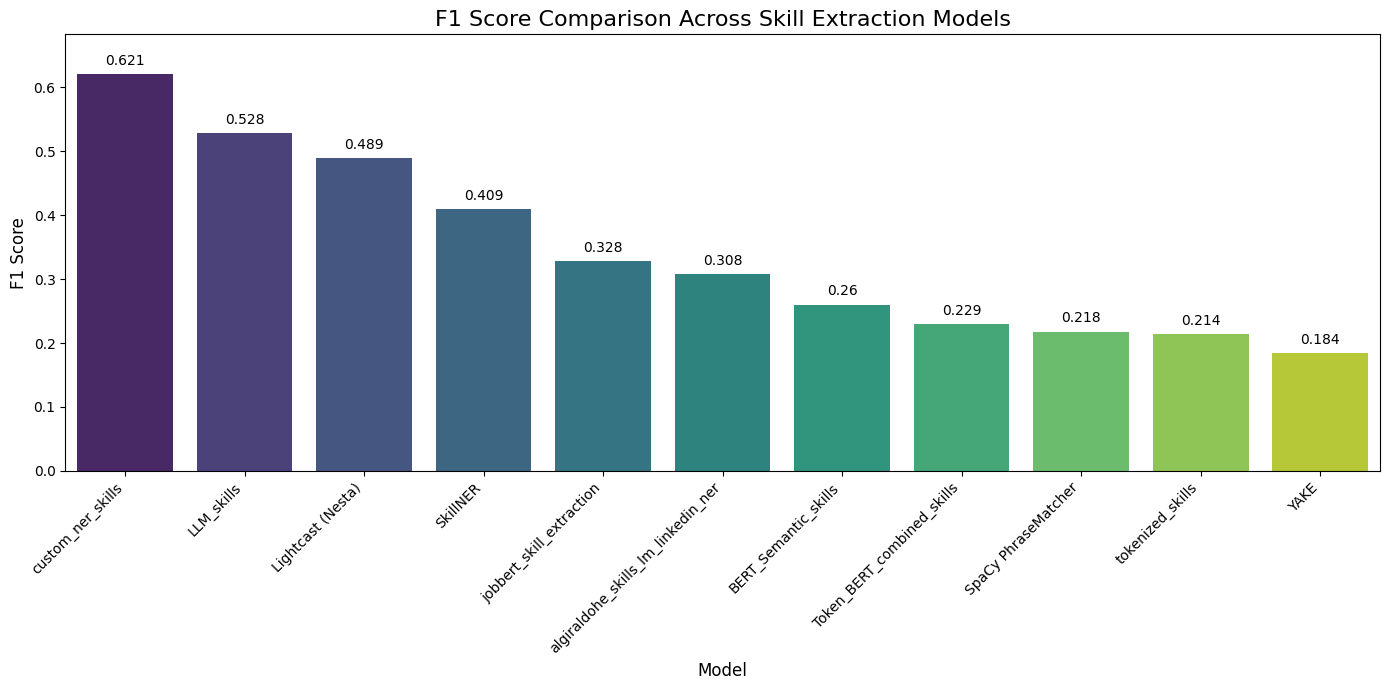

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort data for better visualization
metrics_df_sorted = model_metrics_df.sort_values(by='f1_score', ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 7))
ax = sns.barplot(x='model', y='f1_score', data=metrics_df_sorted, palette='viridis', hue='model', legend=False)

plt.xticks(rotation=45, ha='right')
plt.title('F1 Score Comparison Across Skill Extraction Models', fontsize=16)
plt.ylabel('F1 Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, metrics_df_sorted['f1_score'].max() * 1.1)

# Add F1 scores on top of bars
for index, row in metrics_df_sorted.iterrows():
    ax.text(index, row['f1_score'] + 0.01, round(row['f1_score'], 3), color='black', ha="center", va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Performance Evaluation (Entity-wise)
This evaluates performance of custom NER model and LLM separately for each entity type: skills, education, and experience.

In [ ]:
# -------------------------------------------------------------
# Compare LLM and Custom NER on Skills, Education, Experience
# -------------------------------------------------------------

entities = ['skills', 'education', 'experience']
comparison_rows = []

for ent in entities:
    true_col = f'True_{ent}'
    custom_col = f'custom_ner_{ent}'
    llm_col = f'LLM_{ent}'

    # Normalize
    for col in [true_col, custom_col, llm_col]:
        subset[col] = subset[col].apply(parse_and_normalize)

    # Evaluate
    custom_scores = subset.apply(lambda row: evaluate_soft(row[true_col], row[custom_col]), axis=1)
    llm_scores = subset.apply(lambda row: evaluate_soft(row[true_col], row[llm_col]), axis=1)

    c_precision, c_recall, c_f1, c_jaccard = zip(*custom_scores)
    l_precision, l_recall, l_f1, l_jaccard = zip(*llm_scores)

    comparison_rows.append({
        'Entity': ent,
        'Custom NER_Precision': round(np.mean(c_precision), 3),
        'Custom NER_Recall': round(np.mean(c_recall), 3),
        'Custom NER_F1': round(np.mean(c_f1), 3),
        'Custom NER_Jaccard': round(np.mean(c_jaccard), 3),
        'LLM_Precision': round(np.mean(l_precision), 3),
        'LLM_Recall': round(np.mean(l_recall), 3),
        'LLM_F1': round(np.mean(l_f1), 3),
        'LLM_Jaccard': round(np.mean(l_jaccard), 3),
    })

# Build DataFrame for side-by-side comparison
comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)


,Entity,Custom NER_Precision,Custom NER_Recall,Custom NER_F1,Custom NER_Jaccard,LLM_Precision,LLM_Recall,LLM_F1,LLM_Jaccard
0,skills,0.615,0.727,0.623,0.478,0.654,0.502,0.528,0.387
1,education,0.461,0.430,0.429,0.387,0.530,0.545,0.516,0.471
2,experience,0.629,0.579,0.571,0.507,0.538,0.642,0.551,0.477


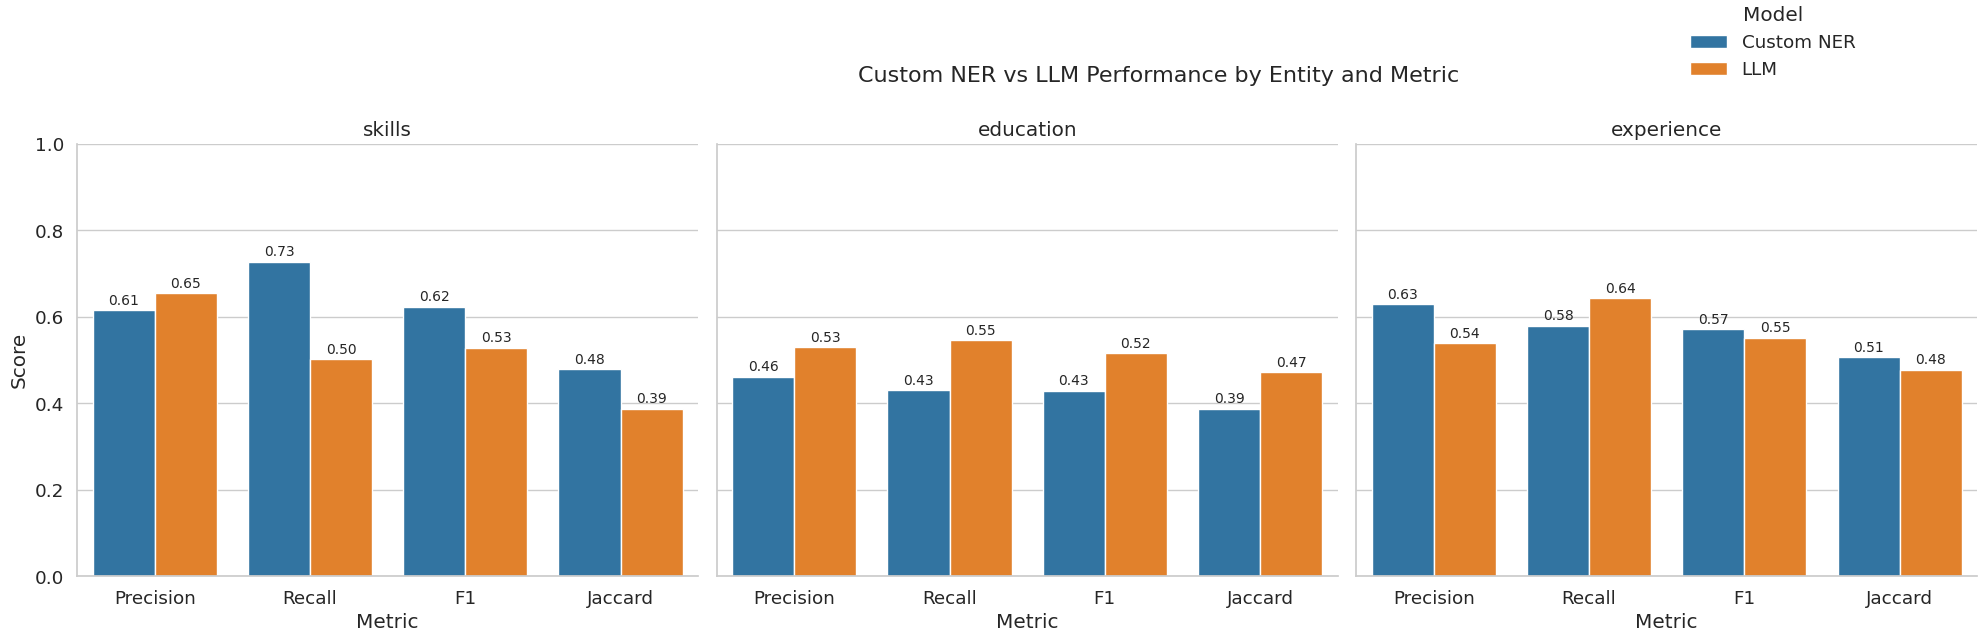

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame
comparison_melted = comparison_df.melt(id_vars="Entity",
                                       var_name="Model_Metric",
                                       value_name="Score")

# Extract Model and Metric
comparison_melted['Model'] = comparison_melted['Model_Metric'].apply(lambda x: 'LLM' if x.startswith('LLM') else 'Custom NER')
comparison_melted['Metric'] = comparison_melted['Model_Metric'].apply(lambda x: '_'.join(x.split('_')[1:]))

# Define custom color palette
palette = {
    'Custom NER': '#1f77b4',
    'LLM': '#ff7f0e'
}

# Seaborn settings
sns.set(style="whitegrid", font_scale=1.2)
g = sns.catplot(
    data=comparison_melted,
    x="Metric",
    y="Score",
    hue="Model",
    col="Entity",
    kind="bar",
    palette=palette,
    height=6,
    aspect=1.2
)

# Add value labels on bars
for ax in g.axes.flat:
    for container in ax.containers:
        labels = [f"{bar.get_height():.2f}" for bar in container]
        ax.bar_label(container, labels=labels, label_type='edge', padding=2, fontsize=10)

# Set titles and axis labels
g.set_titles("{col_name}")
g.set_axis_labels("Metric", "Score")
g.set(ylim=(0, 1))

# Adjust legend to top-right outside plot
g._legend.set_bbox_to_anchor((0.8, 1))
g._legend.set_title("Model")

# Final layout tweaks
plt.tight_layout()
plt.subplots_adjust(top=0.85, right=0.85)
g.fig.suptitle("Custom NER vs LLM Performance by Entity and Metric", fontsize=16)

plt.show()
